In [1]:
import torch
import numpy as np
import random
import time
import os
import matplotlib.pyplot as plt
from model.lf_model import LowFidelityPINN
from model.classic_pinn_model import ClassicalPINN 
from utils.pde_utils import evaluate, get_exact_solution, train_universal
from utils.plot_utils import plot_comparison, plot_theta_field

In [2]:
DOMAINS = {
    'heat': {'x': (0.0, 1.0), 't': (0.0, 0.5)},
    'wave': {'x': (0.0, 1.0), 't': (0.0, 1.0)},
    'burgers': {'x': (-1.0, 1.0), 't': (0.0, 0.5)},
    'reaction_diffusion': {'x': (-1.0, 1.0), 't': (0.0, 0.5)}
}

TITLES = {
    'heat': 'Heat Equation',
    'wave': 'Wave Equation',
    'burgers': 'Burgers Equation',
    'reaction_diffusion': 'Reaction-Diffusion'
}

PDE_CONFIGS = {
    'heat': {'n_steps': 4, 'n_iterations': 2, 'lr': 0.001},
    'wave': {'n_steps': 3, 'n_iterations': 3, 'lr': 0.001},
    'burgers': {'n_steps': 2, 'n_iterations':2, 'lr': 0.001},
    'reaction_diffusion': {'n_steps': 2, 'n_iterations':2, 'lr':0.001}
}

def run_single_test(pde_type, domain, exact_sol, seed, epochs, max_time=None, 
                    target_metric=None, target_value=None):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # ИЗМЕНЕНО: Получаем конфигурацию для конкретного PDE
    config = PDE_CONFIGS.get(pde_type, {'n_steps': 5})
    
    # Model factories for all methods, including fixed theta variants and ClassicalPINN
    model_factories = {
        'learnable_theta': lambda: LowFidelityPINN(
            pde_type, 
            n_steps=config['n_steps'],
            n_iterations = config['n_iterations'],
            lr = config['lr'],
            theta_hidden_dim=2
        ),
        'classical_pinn': lambda: ClassicalPINN(pde_type)
    }
    
    results = {}
    
    for key, factory in model_factories.items():
        display_name = key.replace('_', ' ').title() if key != 'learnable_theta' else 'Low-Fidelity PINN'
        print(f"  {display_name}...", end=' ')
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        start_time = time.time()
        model = factory()
        history = train_universal(model, domain, epochs=epochs, n_collocation=30, 
                                max_time=max_time, target_metric=target_metric, 
                                target_value=target_value)
        res = evaluate(model, domain, exact_solution=exact_sol)
        res['history'] = history
        res['training_time'] = history['training_time']
        res['epochs_completed'] = history['epochs_completed']
        res['converged'] = history['converged']
            
        if hasattr(model, 'get_theta_statistics'):
            theta_stats = model.get_theta_statistics(domain)
            res['theta_mean'] = theta_stats['mean']
            res['theta_std'] = theta_stats['std']
        
        results[key] = res
        print(f"✓ L2RE={res['l2re']:.4e}")
    
    return results

def run_multiple_tests(pde_type, n_runs, epochs, max_time = None, target_value = None, target_metric = None):
    domain = DOMAINS[pde_type]
    title = TITLES[pde_type]
    exact_sol = get_exact_solution(pde_type)
    
    # НОВОЕ: Выводим конфигурацию для этого PDE
    config = PDE_CONFIGS.get(pde_type, {'n_steps': 5})
    
    print(f"\n{'='*80}")
    print(f"ТЕСТИРОВАНИЕ: {title} ({n_runs} runs)")
    print(f"Конфигурация: n_steps={config['n_steps']}")
    print(f"{'='*80}\n")
    
    seeds = [42 + i*111 for i in range(n_runs)]
    all_results = []
    
    for i, seed in enumerate(seeds):
        print(f"\nПрогон {i+1}/{n_runs} (seed={seed}):")
        results = run_single_test(pde_type, domain, exact_sol, seed, epochs, max_time=max_time, target_value = target_value, target_metric = target_metric)
        all_results.append(results)
    
    analyze_and_plot(all_results, title, domain)
    return all_results

def analyze_and_plot(all_results, title, domain):
    methods = ['learnable_theta', 'classical_pinn']
    names = ['Low-Fidelity', 'Classical']
    colors = ['blue', 'green']
    
    stats = {m: {'losses': [], 'l2res': [], 'rmses': [], 'max_errs': [], 'residuals': [], 
                 'training_times': [], 'epochs_completed': [], 'converged_count': []} for m in methods}
    
    for results in all_results:
        for method in methods:
            if method in results:
                res = results[method]
                stats[method]['losses'].append(res['history']['losses'][-1])
                stats[method]['l2res'].append(res['l2re'])
                stats[method]['rmses'].append(res['rmse'])
                stats[method]['max_errs'].append(res['max_err'])
                stats[method]['residuals'].append(res['pde_residual'])
                stats[method]['training_times'].append(res['training_time'])
                stats[method]['epochs_completed'].append(res['epochs_completed'])
                stats[method]['converged_count'].append(1 if res['converged'] else 0)
    
    print(f"\n{'='*120}")
    print(f"СТАТИСТИКА: {title}")
    print(f"{'='*120}")
    print(f"{'Метод':<15} {'Loss (μ±σ)':<18} {'L2RE (μ±σ)':<18} {'RMSE (μ±σ)':<18} {'MaxErr (μ±σ)':<18} {'Residual (μ±σ)':<18} {'Time (μ±σ)':<18} {'Epochs (μ±σ)':<18} {'Converged (%)':<15}")
    print("-" * 150)
    
    for method, name in zip(methods, names):
        losses = stats[method]['losses']
        l2res = stats[method]['l2res']
        rmses = stats[method]['rmses']
        max_errs = stats[method]['max_errs']
        residuals = stats[method]['residuals']
        times = stats[method]['training_times']
        epochs_comp = stats[method]['epochs_completed']
        conv_count = stats[method]['converged_count']
        conv_perc = (sum(conv_count) / len(conv_count)) * 100 if conv_count else 0
        
        if losses:
            print(f"{name:<15} {np.mean(losses):.2e}±{np.std(losses):.1e}  "
                  f"{np.mean(l2res):.2e}±{np.std(l2res):.1e}  "
                  f"{np.mean(rmses):.2e}±{np.std(rmses):.1e}  "
                  f"{np.mean(max_errs):.2e}±{np.std(max_errs):.1e}  "
                  f"{np.mean(residuals):.2e}±{np.std(residuals):.1e}  "
                  f"{np.mean(times):.2f}±{np.std(times):.1f}  "
                  f"{'{:.0f}±{:.0f}'.format(np.mean(epochs_comp), np.std(epochs_comp)):<18} {conv_perc:.0f}%")
    
    # ГРАФИКИ: 3x2 для дополнительных метрик
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    
    # 1. Средние L2RE
    ax = axes[0, 0]
    means = [np.mean(stats[m]['l2res']) for m in methods]
    stds = [np.std(stats[m]['l2res']) for m in methods]
    x_pos = np.arange(len(names))
    
    bars = ax.bar(x_pos, means, yerr=stds, capsize=5, color=colors, 
                  alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(names, rotation=15, ha='right')
    ax.set_ylabel('L2 Relative Error', fontsize=12)
    ax.set_title(f'{title}: L2RE Accuracy', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_yscale('log')
    
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height * 1.5,
                f'{mean:.2e}\n±{std:.1e}', ha='center', va='bottom', fontsize=9)
    
    # 2. Эволюция потерь (пример из первого run)
    ax = axes[0, 1]
    for method, name, color in zip(methods, names, colors):
        if method in all_results[0] and 'history' in all_results[0][method]:
            losses = all_results[0][method]['history']['losses']
            ax.semilogy(losses, label=name, color=color, linewidth=2, alpha=0.8)
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title('Training Loss (Example Run)', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # 3. Эволюция θ (пример из первого run)
    ax = axes[1, 0]
    if 'learnable_theta' in all_results[0] and 'history' in all_results[0]['learnable_theta']:
        history = all_results[0]['learnable_theta']['history']
        if 'theta_statistics' in history and history['theta_statistics']:
            theta_stats = [s for s in history['theta_statistics'] if s is not None]
            
            if theta_stats:
                theta_means = [s['mean'] for s in theta_stats]
                theta_stds = [s['std'] for s in theta_stats]
                epochs = range(len(theta_means))
                
                ax.plot(epochs, theta_means, 'r-', linewidth=3, label='θ (mean)', alpha=0.8)
                ax.fill_between(epochs, np.array(theta_means) - np.array(theta_stds),
                               np.array(theta_means) + np.array(theta_stds),
                               alpha=0.2, color='red', label='±σ')
                
                ax.axhline(0.0, color='blue', linestyle='--', linewidth=2, alpha=0.7, label='Implicit')
                ax.axhline(0.5, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Trapezoidal')
                ax.axhline(1.0, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Explicit')
                
                ax.set_xlabel('Epoch', fontsize=12)
                ax.set_ylabel('θ', fontsize=12)
                ax.set_title('θ Evolution (Example Run)', fontsize=14, fontweight='bold')
                ax.legend(fontsize=10)
                ax.grid(True, alpha=0.3)
                ax.set_ylim(-0.1, 1.1)
    
    # 4. θ среднее по всем runs
    ax = axes[1, 1]
    theta_data = []
    for results in all_results:
        if 'learnable_theta' in results:
            theta_mean = results['learnable_theta'].get('theta_mean')
            if theta_mean is not None and isinstance(theta_mean, (int, float)):
                theta_data.append(theta_mean)
    
    if theta_data:
        theta_mean_overall = np.mean(theta_data)
        theta_std_overall = np.std(theta_data)
        
        ax.bar(['Low-Fidelity'], [theta_mean_overall], yerr=[theta_std_overall], 
               capsize=10, color='red', alpha=0.7, edgecolor='black', linewidth=1.5)
        
        ax.axhline(0.0, color='blue', linestyle='--', linewidth=2, alpha=0.7, label='Implicit')
        ax.axhline(0.5, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Trapezoidal')
        ax.axhline(1.0, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Explicit')
        
        ax.text(0, theta_mean_overall + theta_std_overall * 1.2,
                f'{theta_mean_overall:.3f}±{theta_std_overall:.3f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        ax.set_ylabel('θ', fontsize=12)
        ax.set_title(f'θ Average Across {len(theta_data)} Runs', fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(-0.1, 1.1)
    
    # 5. Средние RMSE
    ax = axes[2, 0]
    means = [np.mean(stats[m]['rmses']) for m in methods]
    stds = [np.std(stats[m]['rmses']) for m in methods]
    
    bars = ax.bar(x_pos, means, yerr=stds, capsize=5, color=colors, 
                  alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(names, rotation=15, ha='right')
    ax.set_ylabel('RMSE', fontsize=12)
    ax.set_title(f'{title}: RMSE', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_yscale('log')
    
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height * 1.5,
                f'{mean:.2e}\n±{std:.1e}', ha='center', va='bottom', fontsize=9)
    
    # 6. Средние Training Times
    ax = axes[2, 1]
    means = [np.mean(stats[m]['training_times']) for m in methods]
    stds = [np.std(stats[m]['training_times']) for m in methods]
    
    bars = ax.bar(x_pos, means, yerr=stds, capsize=5, color=colors, 
                  alpha=0.7, edgecolor='black', linewidth=1.5)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(names, rotation=15, ha='right')
    ax.set_ylabel('Training Time (s)', fontsize=12)
    ax.set_title(f'{title}: Training Time', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + std * 0.1,
                f'{mean:.2f}\n±{std:.1f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    plot_solutions(all_results[0], title, domain)

def plot_solutions(results, title, domain):
    methods = ['learnable_theta', 'classical_pinn']
    names = ['Low-Fidelity', 'Classical']
    colors = ['blue', 'green']
    
    if 'learnable_theta' not in results or 'u_exact' not in results['learnable_theta']:
        return
    
    points = results['learnable_theta']['points'].cpu()
    grid_shape = results['learnable_theta']['grid_shape']
    
    x_vals = points[:, 0].numpy().reshape(grid_shape)
    t_vals = points[:, 1].numpy().reshape(grid_shape)
    u_exact = results['learnable_theta']['u_exact'].cpu().numpy().reshape(grid_shape)
    
    times = np.linspace(t_vals[0, :].min(), t_vals[0, :].max(), 3)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'{title}: Solutions u(x,t)', fontsize=16, fontweight='bold')
    
    for i, t0 in enumerate(times):
        ax = axes[i]
        idx = np.argmin(np.abs(t_vals[0, :] - t0))
        
        ax.plot(x_vals[:, idx], u_exact[:, idx], 'k-', linewidth=3, label='Exact', alpha=0.8)
        
        for method, name, color in zip(methods, names, colors):
            if method in results and 'u_pred' in results[method]:
                u_pred = results[method]['u_pred'].cpu().numpy().reshape(grid_shape)
                ax.plot(x_vals[:, idx], u_pred[:, idx], '--', color=color, linewidth=2, label=name, alpha=0.7)
        
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('u(x,t)', fontsize=12)
        ax.set_title(f't = {t0:.3f}', fontsize=13)
        if i == 0:
            ax.legend(fontsize=9, loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def run_all_pde_tests(epochs=500, max_time=None, target_value = None, target_metric = None):
    configs = [('heat', 5), ('wave', 5), ('burgers', 5), ('reaction_diffusion', 5)]
    all_pde_results = {}
    
    for pde, n_runs in configs:
        print(f"\n\n{'#'*80}")
        print(f"# {pde.upper()}")
        print(f"{'#'*80}\n")
        results = run_multiple_tests(pde, n_runs=n_runs, epochs=epochs, max_time=max_time, target_value = target_value, target_metric = target_metric)
        all_pde_results[pde] = results
    
    plot_final_comparison(all_pde_results)
    return all_pde_results

def plot_final_comparison(all_pde_results):
    methods = ['learnable_theta', 'classical_pinn']
    names = ['Low-Fidelity', 'Classical']
    colors = ['blue', 'green']
    pde_names = ['Heat', 'Wave', 'Burgers', 'Reaction-Diff']
    
    # L2RE comparison
    fig, ax = plt.subplots(figsize=(14, 8))
    x_pos = np.arange(len(pde_names))
    bar_width = 0.15
    
    for i, (method, name, color) in enumerate(zip(methods, names, colors)):
        means, stds = [], []
        for pde_type, results_list in all_pde_results.items():
            l2res = [r[method]['l2re'] for r in results_list if method in r]
            means.append(np.mean(l2res) if l2res else 0)
            stds.append(np.std(l2res) if l2res else 0)
        
        ax.bar(x_pos + i*bar_width, means, bar_width, yerr=stds, label=name, 
               color=color, alpha=0.7, capsize=3, edgecolor='black', linewidth=1)
    
    ax.set_xlabel('PDE Type', fontsize=14, fontweight='bold')
    ax.set_ylabel('L2 Relative Error (μ±σ)', fontsize=14, fontweight='bold')
    ax.set_title('All Methods on All PDEs: L2RE', fontsize=16, fontweight='bold')
    ax.set_xticks(x_pos + bar_width*2)
    ax.set_xticklabels(pde_names, fontsize=12)
    ax.legend(fontsize=11, loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Training Time comparison
    fig, ax = plt.subplots(figsize=(14, 8))
    
    for i, (method, name, color) in enumerate(zip(methods, names, colors)):
        means, stds = [], []
        for pde_type, results_list in all_pde_results.items():
            times = [r[method]['training_time'] for r in results_list if method in r]
            means.append(np.mean(times) if times else 0)
            stds.append(np.std(times) if times else 0)
        
        ax.bar(x_pos + i*bar_width, means, bar_width, yerr=stds, label=name, 
               color=color, alpha=0.7, capsize=3, edgecolor='black', linewidth=1)
    
    ax.set_xlabel('PDE Type', fontsize=14, fontweight='bold')
    ax.set_ylabel('Training Time (s) (μ±σ)', fontsize=14, fontweight='bold')
    ax.set_title('All Methods on All PDEs: Training Time', fontsize=16, fontweight='bold')
    ax.set_xticks(x_pos + bar_width*2)
    ax.set_xticklabels(pde_names, fontsize=12)
    ax.legend(fontsize=11, loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()



################################################################################
# HEAT
################################################################################


ТЕСТИРОВАНИЕ: Heat Equation (5 runs)
Конфигурация: n_steps=4


Прогон 1/5 (seed=42):
  Low-Fidelity PINN... 
Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: heat | Max Steps: 4 | Params: 13
Iterations: 2 | LR: 0.001 | Max h: 0.1

   Epoch    0: Loss=1.08e+00, PDE=1.08e+00, θ=0.570±0.011
   Training stopped after 358 epochs due to time limit (60s). Elapsed: 60.02s
✓ L2RE=1.6307e-02
  Classical Pinn...    Epoch    0: Loss=7.04e-01, PDE=2.81e-02, Classical PINN
   Training stopped after 81249 epochs due to time limit (60s). Elapsed: 60.00s
✓ L2RE=2.3223e-02

Прогон 2/5 (seed=153):
  Low-Fidelity PINN... 
Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: heat | Max Steps: 4 | Params: 13
Iterations: 2 | LR: 0.001 | Max h: 0.1

   Epoch    0: Loss=2.00e-01, PDE=2.00e-01, θ=0.529±0.011
   Training stopped after 3

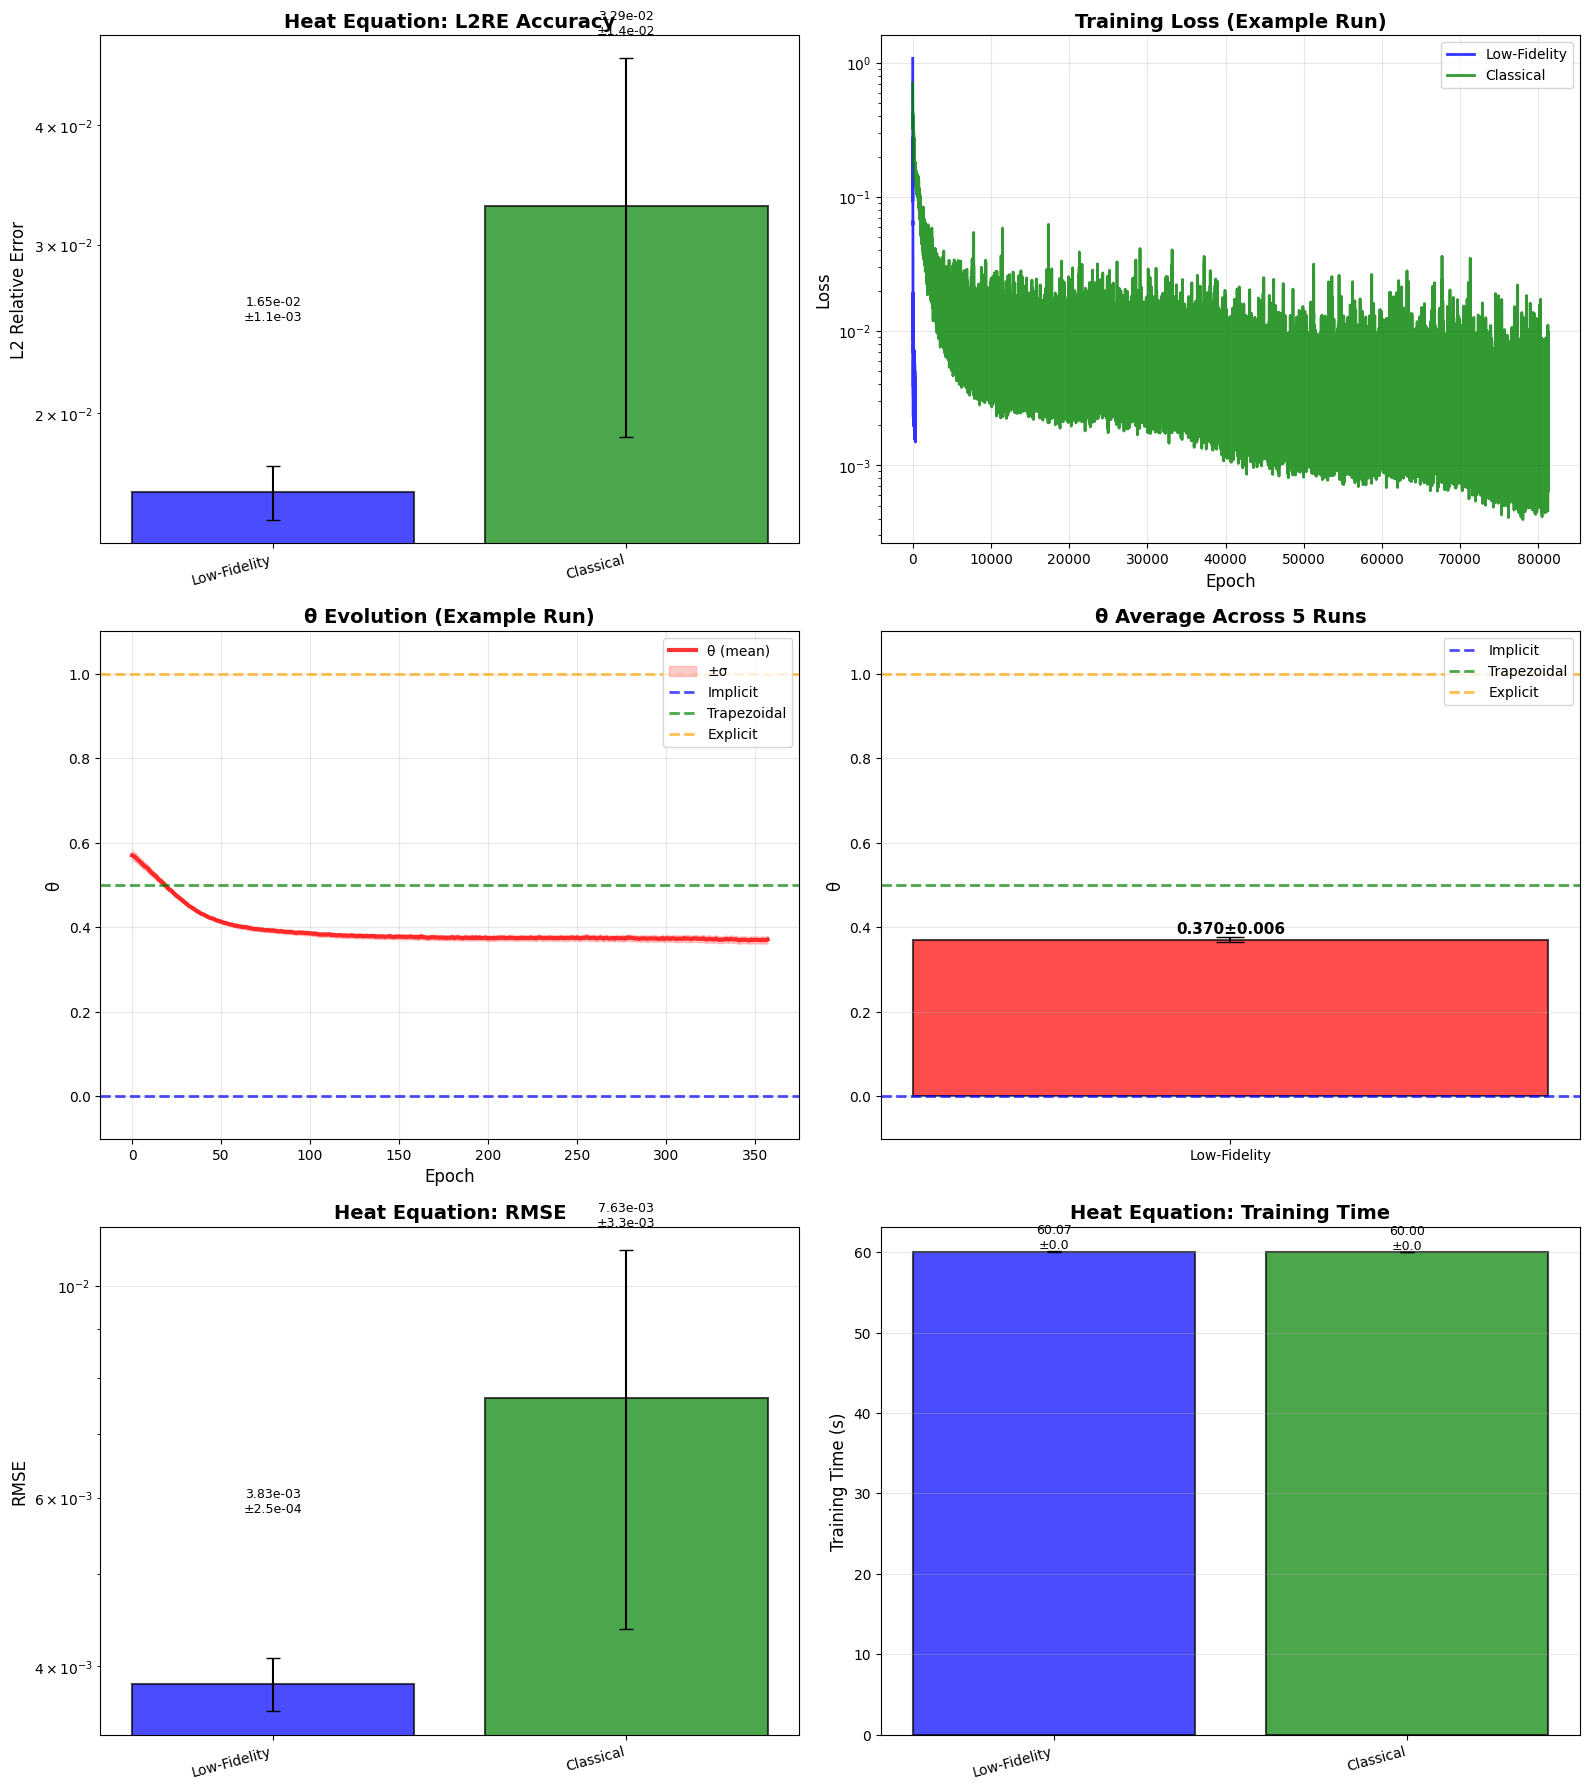

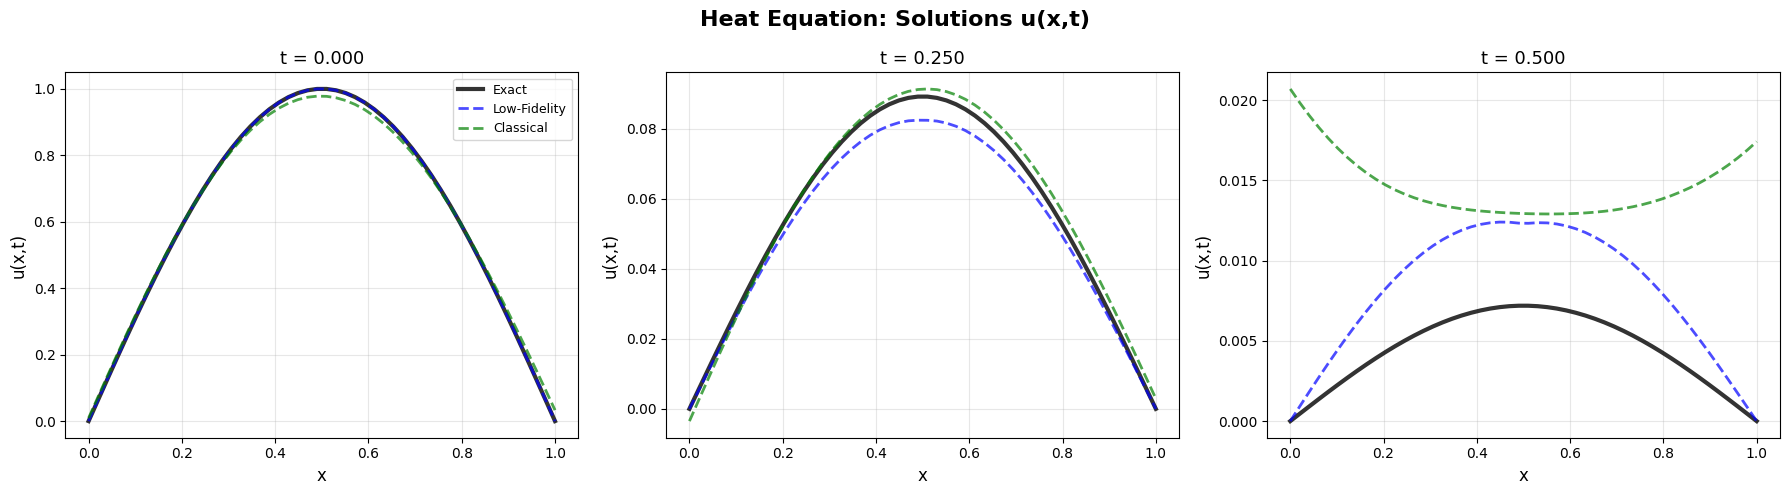



################################################################################
# WAVE
################################################################################


ТЕСТИРОВАНИЕ: Wave Equation (5 runs)
Конфигурация: n_steps=3


Прогон 1/5 (seed=42):
  Low-Fidelity PINN... 
Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: wave | Max Steps: 3 | Params: 13
Iterations: 3 | LR: 0.001 | Max h: 0.1

   Epoch    0: Loss=6.52e+00, PDE=6.52e+00, θ=0.572±0.013
   Training stopped after 106 epochs due to time limit (60s). Elapsed: 60.27s
✓ L2RE=3.1266e-02
  Classical Pinn...    Epoch    0: Loss=7.41e-01, PDE=2.67e-04, Classical PINN
   Training stopped after 66524 epochs due to time limit (60s). Elapsed: 60.00s
✓ L2RE=1.8057e-02

Прогон 2/5 (seed=153):
  Low-Fidelity PINN... 
Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: wave | Max Steps: 3 | Params: 13
Iterations: 3 | LR: 0.001 | Max h: 0.1

   Epoch    0: Loss=2.88e+00, PDE=2.88e+00, θ=0.533±0.012
   Training stopped after 9

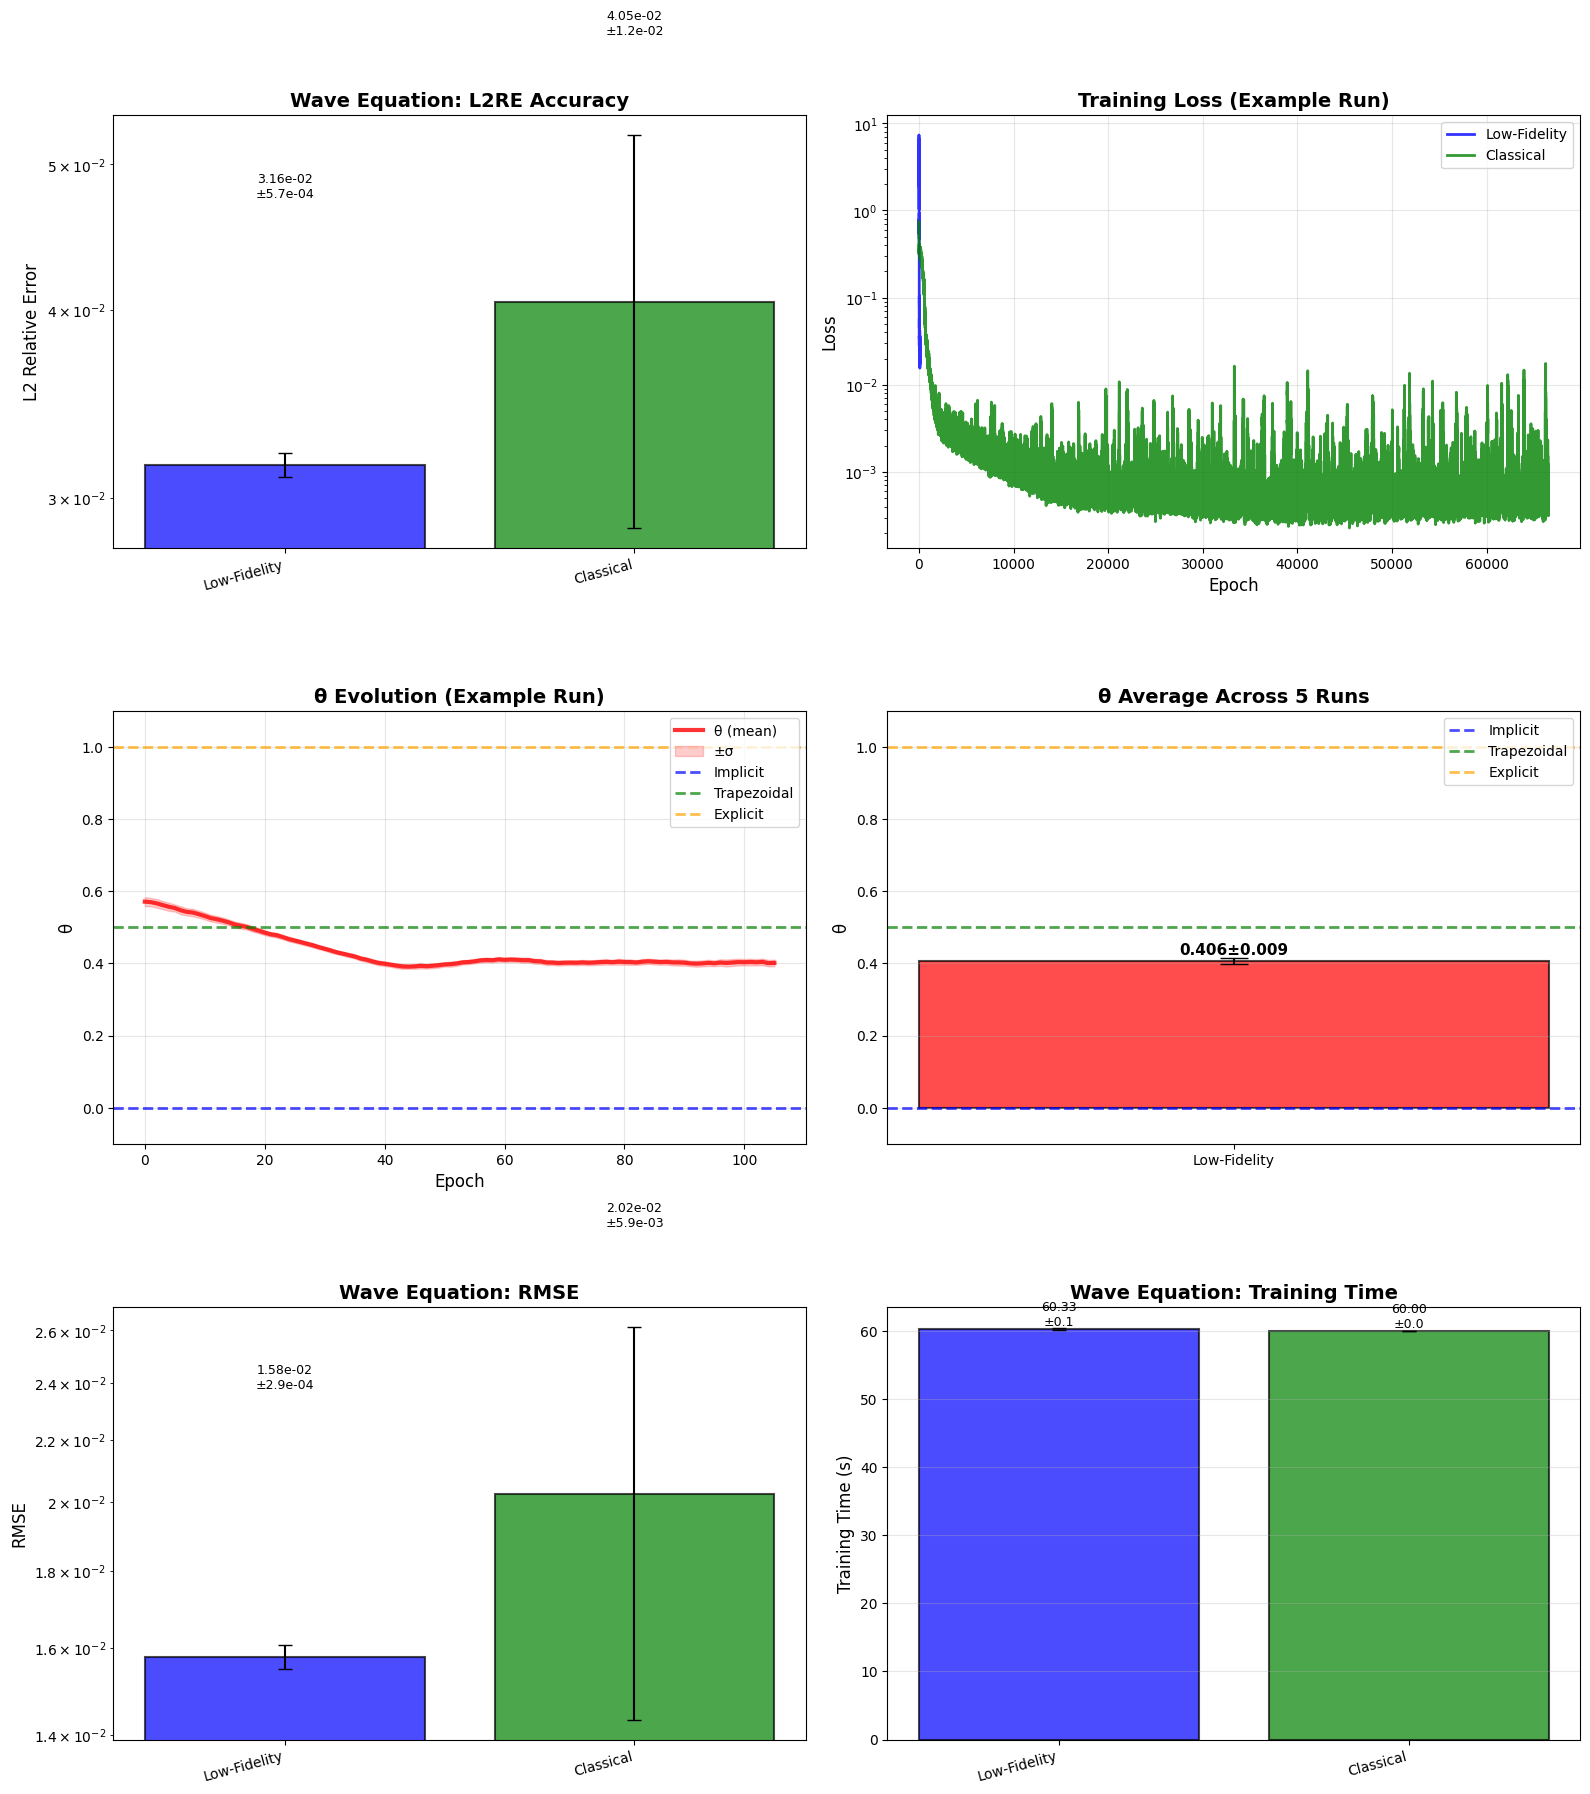

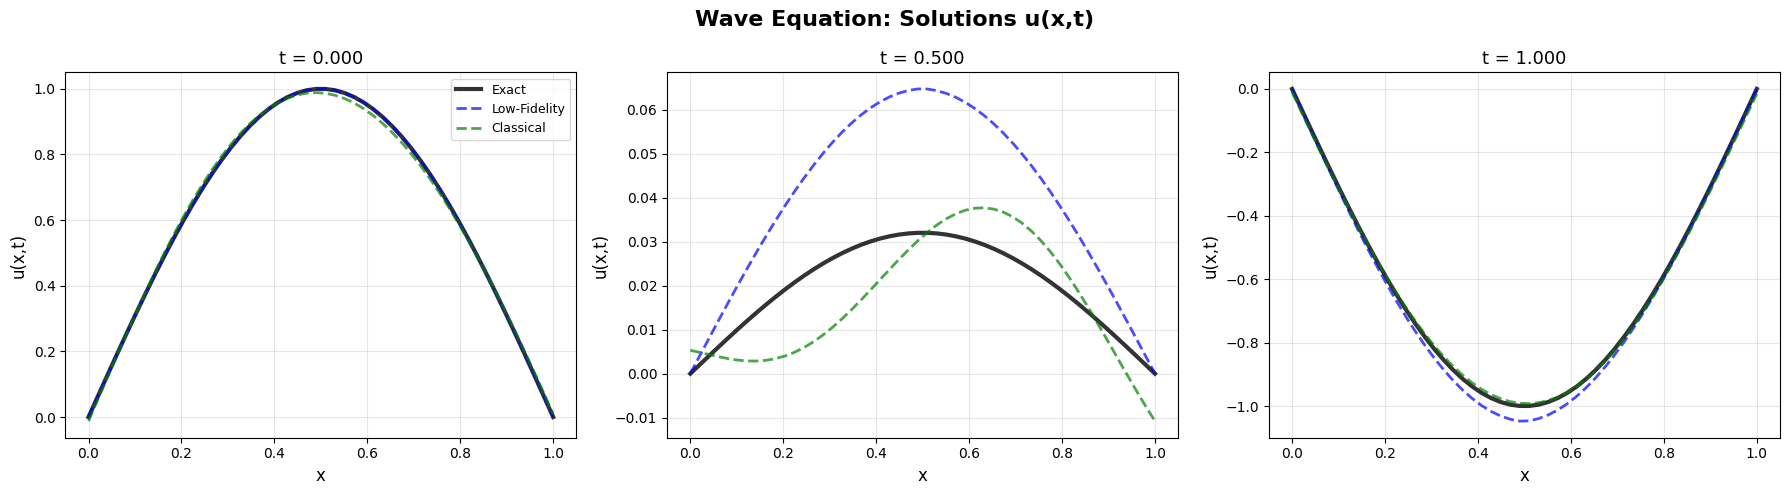



################################################################################
# BURGERS
################################################################################


ТЕСТИРОВАНИЕ: Burgers Equation (5 runs)
Конфигурация: n_steps=2


Прогон 1/5 (seed=42):
  Low-Fidelity PINN... 
Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: burgers | Max Steps: 2 | Params: 13
Iterations: 2 | LR: 0.001 | Max h: 0.1

   Epoch    0: Loss=1.80e+02, PDE=1.80e+02, θ=0.545±0.025
   Training stopped after 151 epochs due to time limit (60s). Elapsed: 60.20s


/Users/igor.velikorechanin/Downloads/trapezoidal_LF_model-main/utils/pde_utils.py:300: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  phi_x, _ = quad(integrand_phi_x, limit_low, limit_high,


✓ L2RE=1.6116e-01
  Classical Pinn...    Epoch    0: Loss=7.41e-01, PDE=2.65e-02, Classical PINN
   Training stopped after 83096 epochs due to time limit (60s). Elapsed: 60.00s
✓ L2RE=2.8904e-01

Прогон 2/5 (seed=153):
  Low-Fidelity PINN... 
Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: burgers | Max Steps: 2 | Params: 13
Iterations: 2 | LR: 0.001 | Max h: 0.1

   Epoch    0: Loss=1.87e+00, PDE=1.87e+00, θ=0.521±0.020
   Training stopped after 150 epochs due to time limit (60s). Elapsed: 60.13s
✓ L2RE=1.6178e-01
  Classical Pinn...    Epoch    0: Loss=5.73e-01, PDE=1.64e-02, Classical PINN
   Training stopped after 82536 epochs due to time limit (60s). Elapsed: 60.00s
✓ L2RE=2.8650e-01

Прогон 3/5 (seed=264):
  Low-Fidelity PINN... 
Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: burgers | Max Steps: 2 | Params: 13
Iterations: 2 | LR: 0.001 | Max h: 0.1

   Epoch    0: Loss=8.57e+00, PDE=8.57e+00, θ=0.555±0.018
   Training stopped after 150 epochs due to time limit (60s)

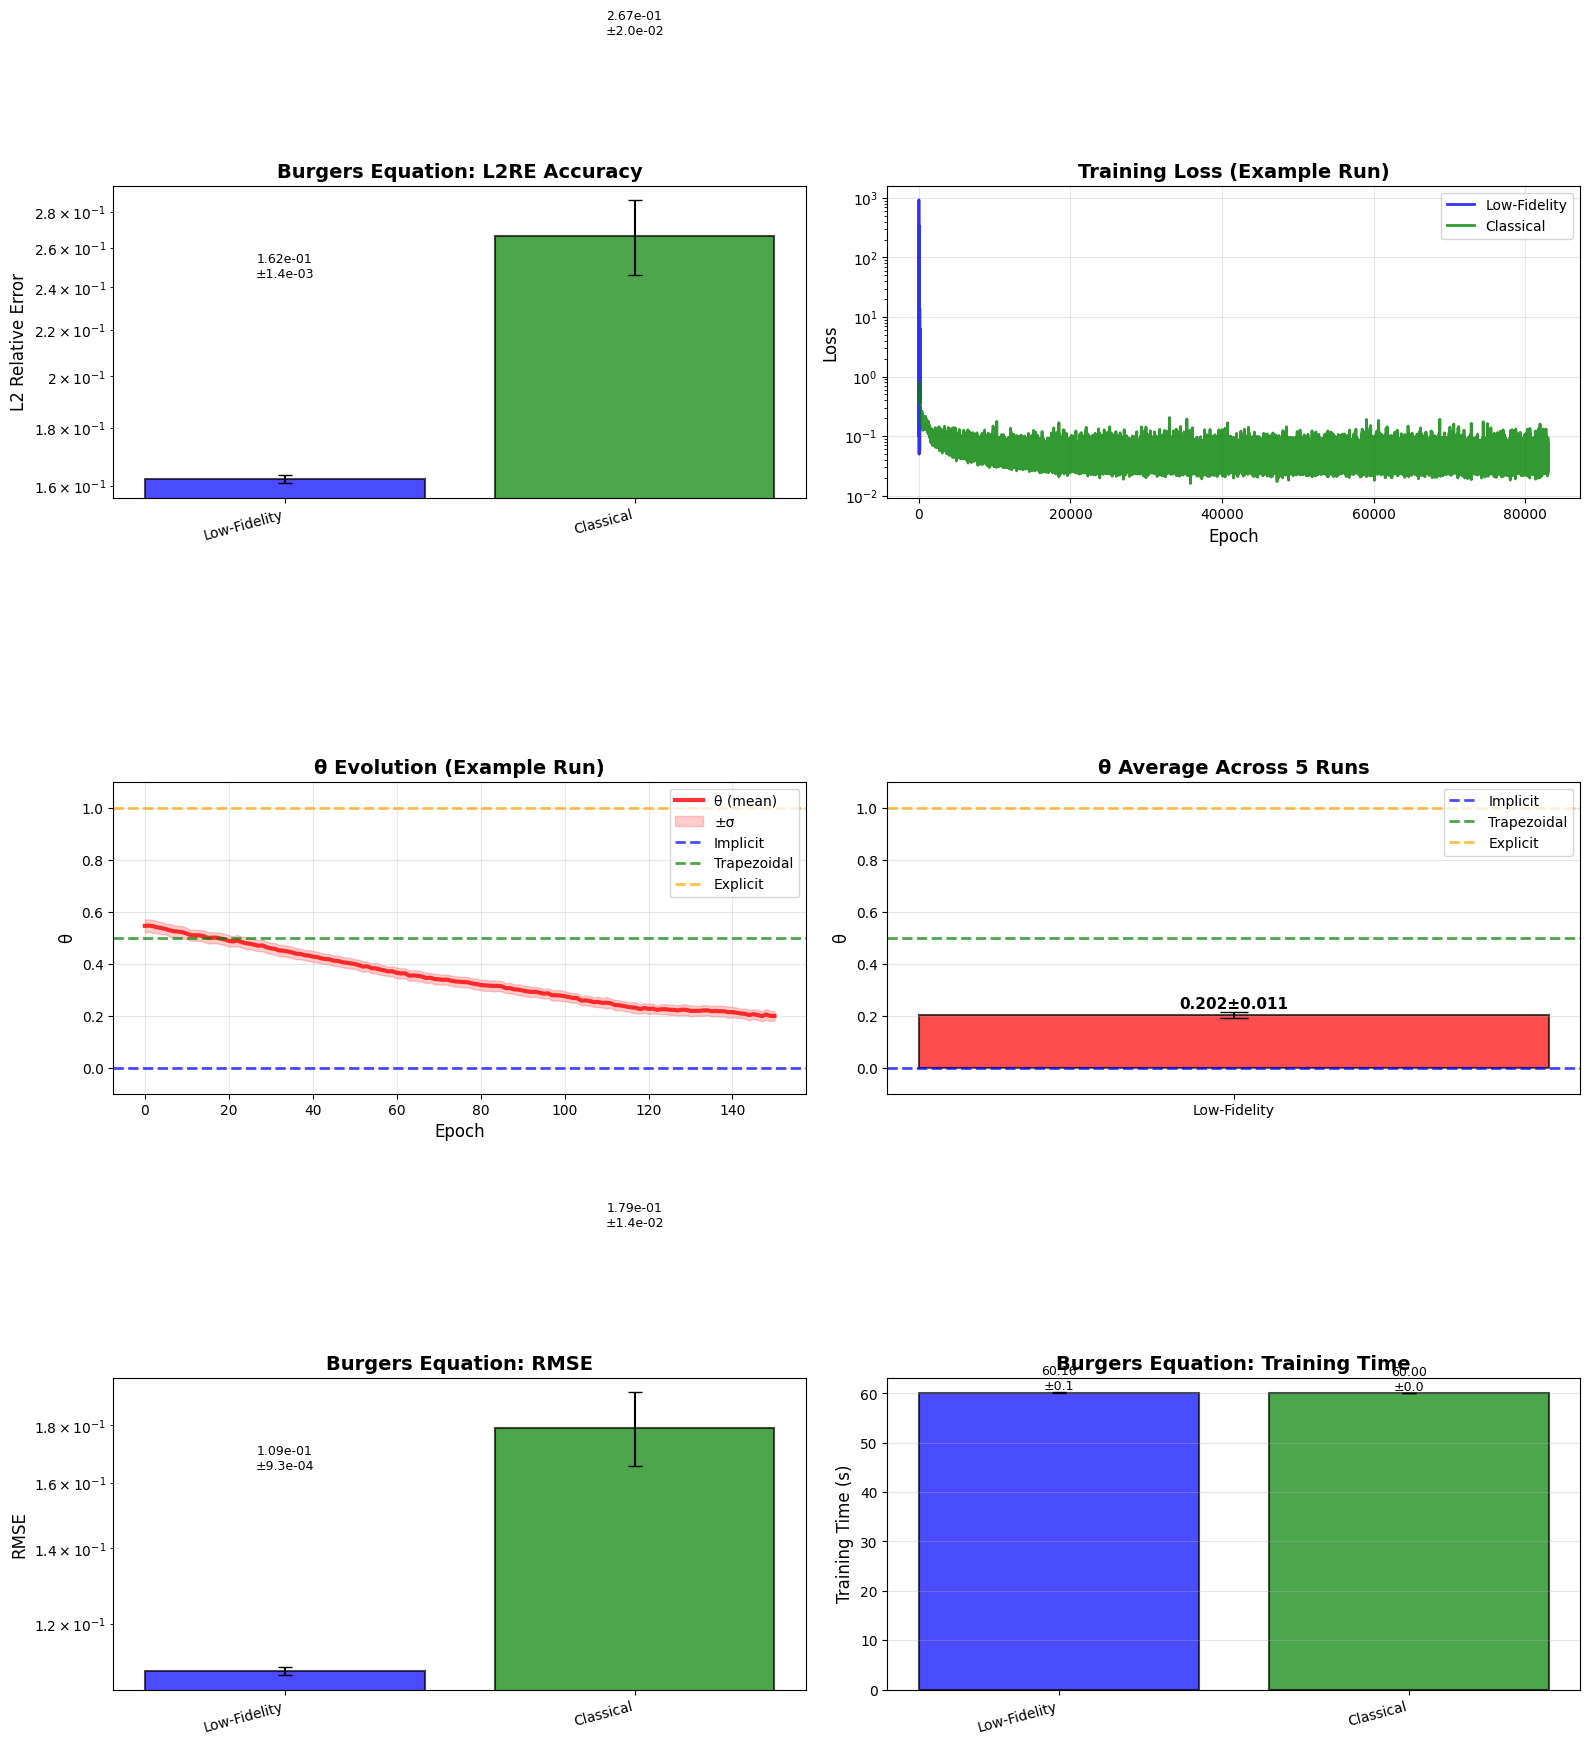

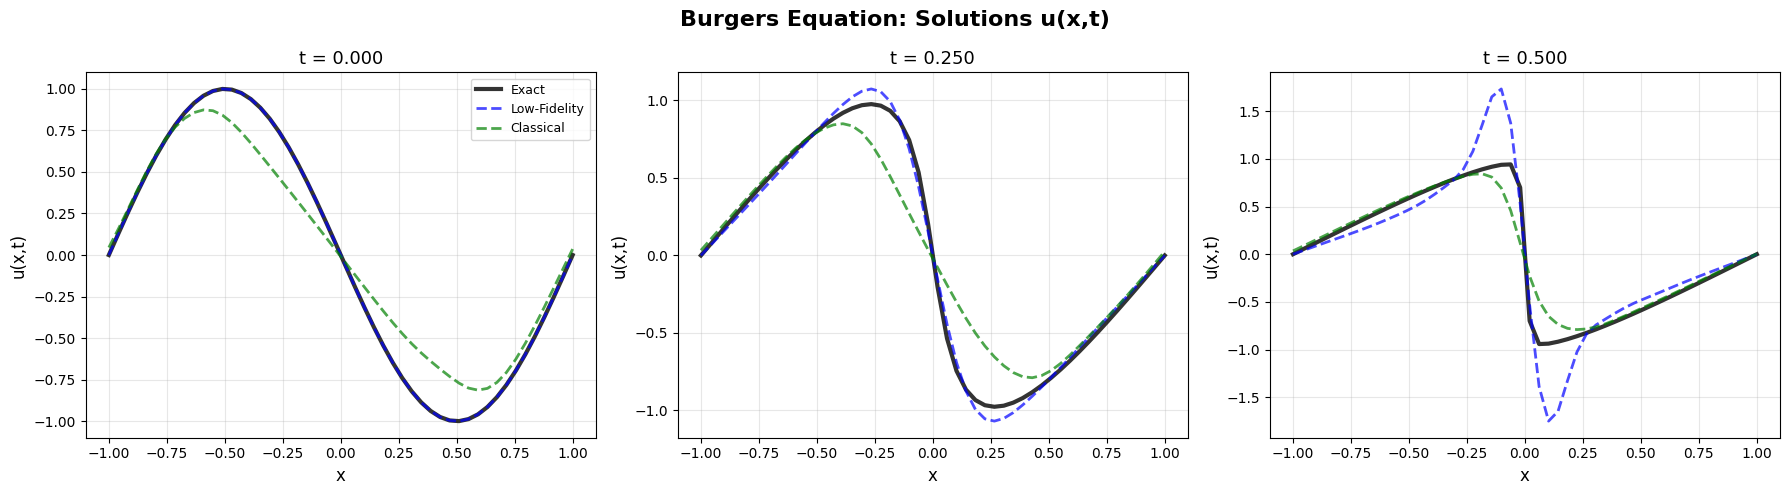



################################################################################
# REACTION_DIFFUSION
################################################################################


ТЕСТИРОВАНИЕ: Reaction-Diffusion (5 runs)
Конфигурация: n_steps=2


Прогон 1/5 (seed=42):
  Low-Fidelity PINN... 
Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: reaction_diffusion | Max Steps: 2 | Params: 13
Iterations: 2 | LR: 0.001 | Max h: 0.1

   Epoch    0: Loss=7.44e-04, PDE=7.44e-04, θ=0.545±0.025
   Training stopped after 124 epochs due to time limit (60s). Elapsed: 60.08s
✓ L2RE=1.2396e-01
  Classical Pinn...    Epoch    0: Loss=5.64e-01, PDE=1.54e-02, Classical PINN
   Training stopped after 77529 epochs due to time limit (60s). Elapsed: 60.00s
✓ L2RE=1.2424e-01

Прогон 2/5 (seed=153):
  Low-Fidelity PINN... 
Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: reaction_diffusion | Max Steps: 2 | Params: 13
Iterations: 2 | LR: 0.001 | Max h: 0.1

   Epoch    0: Loss=4.41e-04, PDE=4.41

/var/folders/dj/lx3_x92x6kn7w2t8440clyjw0000gp/T/ipykernel_2955/3040240637.py:275: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


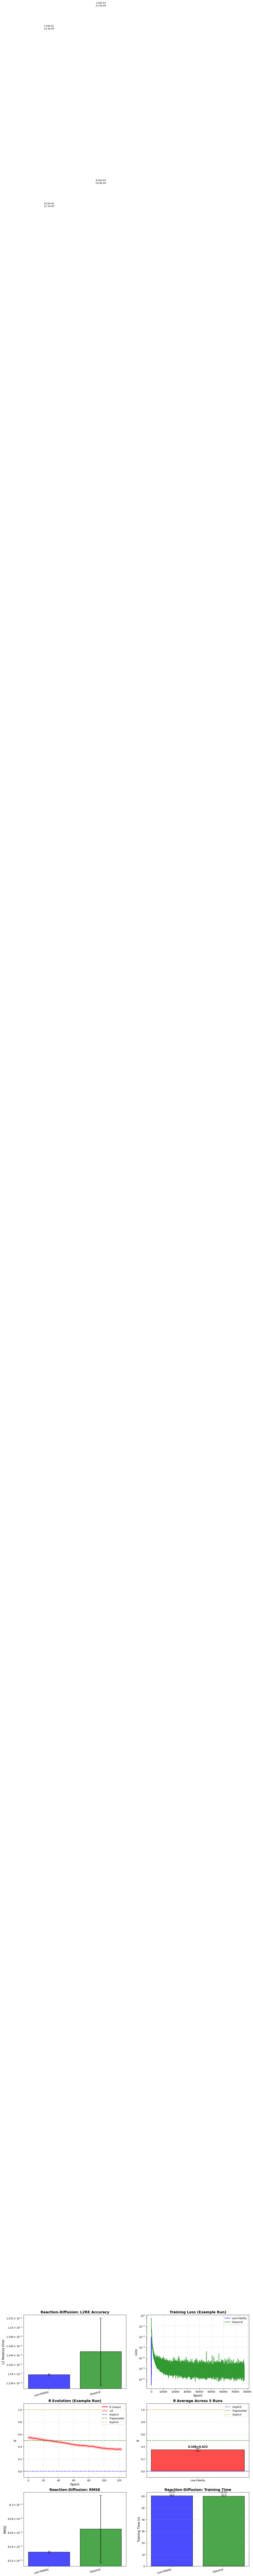

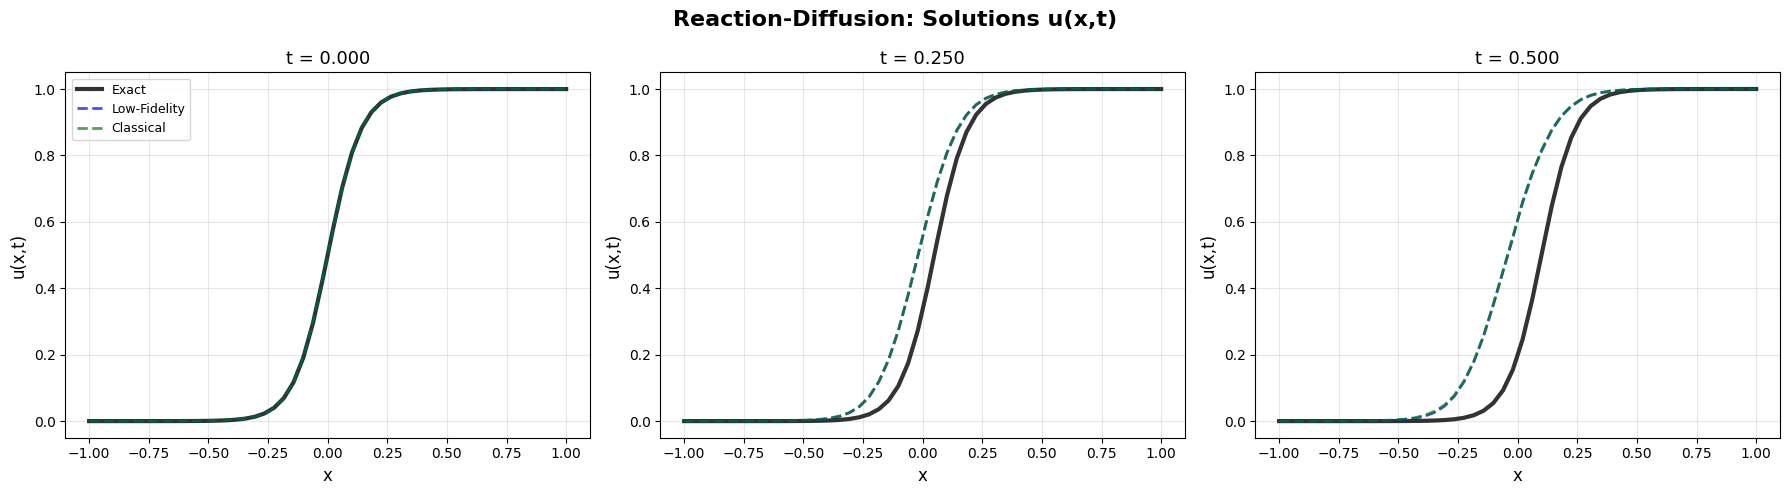

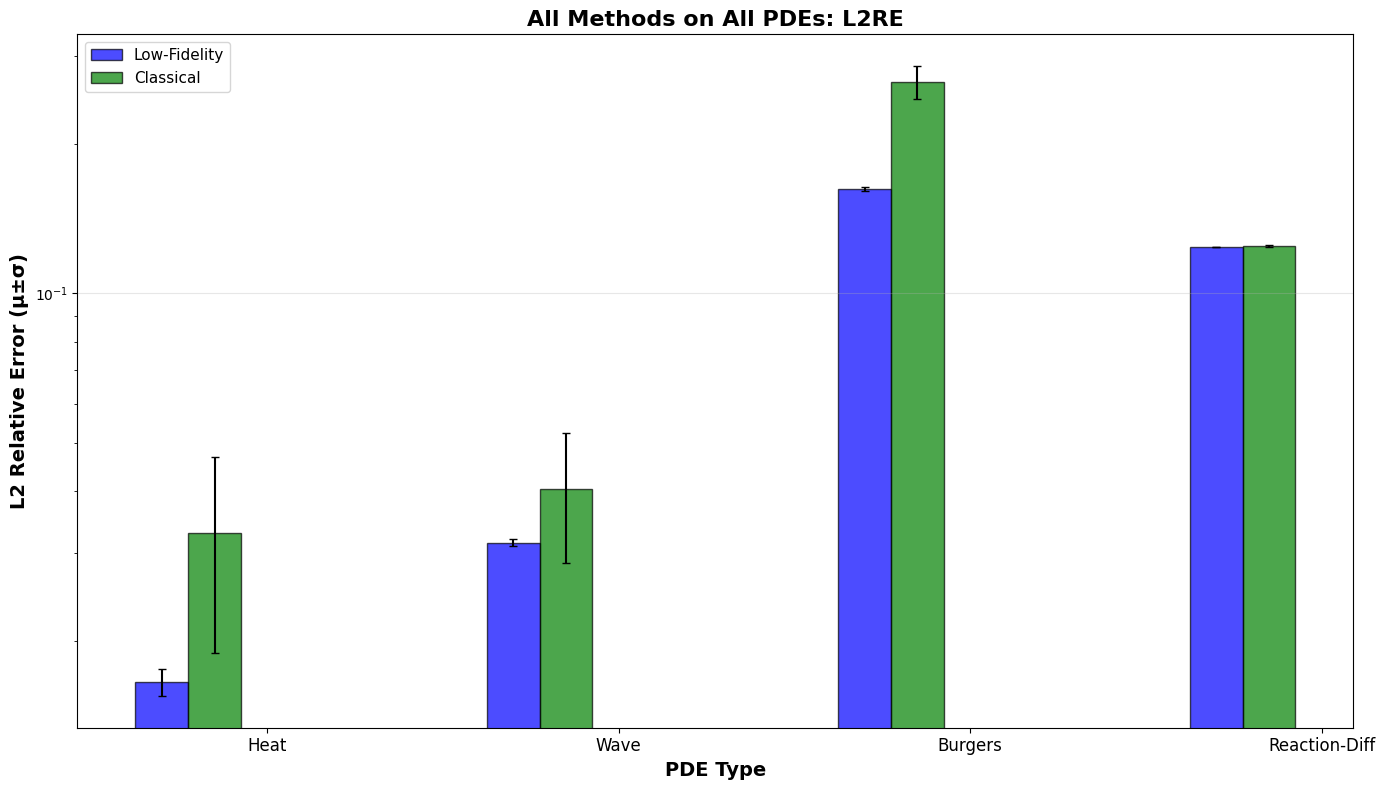

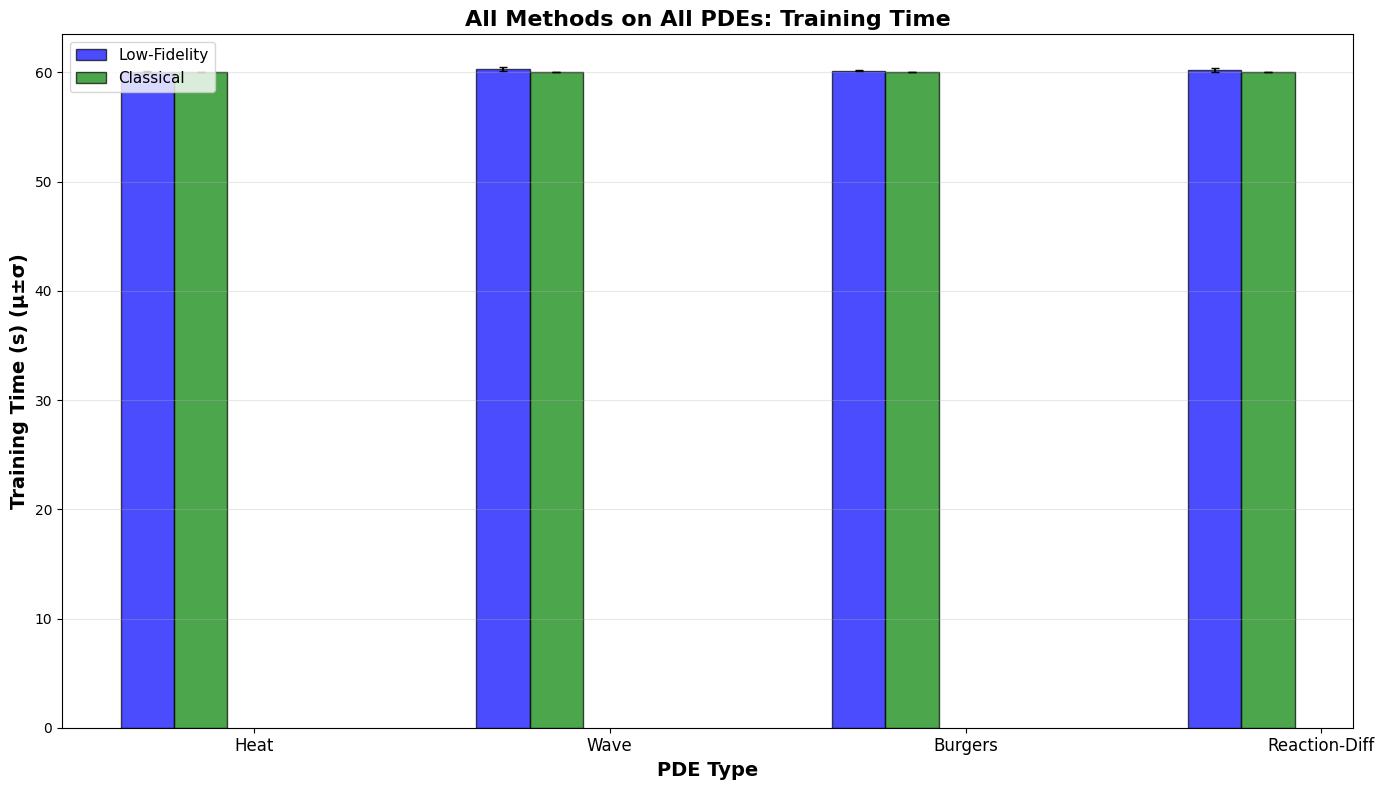

{'heat': [{'learnable_theta': {'points': tensor([[0.0000, 0.0000],
            [0.0000, 0.0102],
            [0.0000, 0.0204],
            ...,
            [1.0000, 0.4796],
            [1.0000, 0.4898],
            [1.0000, 0.5000]]),
    'u_pred': tensor([[ 0.0000e+00],
            [ 0.0000e+00],
            [ 0.0000e+00],
            ...,
            [-1.2690e-09],
            [-1.2261e-09],
            [-1.1904e-09]]),
    'grid_shape': (50, 50),
    'pde_type': 'heat',
    'pde_residual': 0.003162957960739732,
    'theta_statistics': {'mean': 0.3696534335613251,
     'std': 0.008277187123894691,
     'min': 0.3596840798854828,
     'max': 0.3872348666191101},
    'is_spatial_2d': False,
    'model_type': 'LowFidelityPINN',
    'u_exact': tensor([[ 0.0000e+00],
            [ 0.0000e+00],
            [ 0.0000e+00],
            ...,
            [-7.6903e-10],
            [-6.9535e-10],
            [-6.2873e-10]]),
    'error': tensor([[0.0000e+00],
            [0.0000e+00],
         

In [3]:
run_all_pde_tests(epochs=1000000, max_time = 60)

In [ ]:
def test_heat(n_steps, n_iterations, lr, epochs, max_h):
    """Тест уравнения теплопроводности"""
    print("\n" + "="*60)
    print("ТЕСТ: Уравнение теплопроводности")
    print("="*60)
    
    model = LowFidelityPINN('heat', n_steps=n_steps, theta_hidden_dim=2, n_iterations=n_iterations, lr = lr, max_h = max_h)
    domain = {'x': (0.0, 1.0), 't': (0.0, 0.5)}
    exact_sol = get_exact_solution('heat')
    
    history = train_universal(model, domain, epochs=epochs, n_collocation=50)
    results = evaluate(model, domain, exact_solution=exact_sol)
    
    if isinstance(results['theta_statistics'], dict):
        theta_stats = results['theta_statistics']
        print(f"\nРезультаты:")
        print(f"  θ (среднее): {theta_stats['mean']:.4f} ± {theta_stats['std']:.4f}")
        print(f"  θ (диапазон): [{theta_stats['min']:.4f}, {theta_stats['max']:.4f}]")
    
    print(f"  PDE остаток: {results['pde_residual']:.2e}")
    if 'rmse' in results:
        print(f"  RMSE ошибка: {results['rmse']:.2e}")
        print(f"  L2RE ошибка: {results['l2re']:.2e}")
    
    plot(results, history, "Heat Equation - Low-Fidelity PINN")
    plot_theta_field(model, domain, "Heat Equation")
    
    return results, history


def test_wave(n_steps, n_iterations, lr, epochs, max_h):
    """Тест волнового уравнения"""
    print("\n" + "="*60)
    print("ТЕСТ: Волновое уравнение")
    print("="*60)
    
    model = LowFidelityPINN('wave', n_steps=n_steps, theta_hidden_dim=2, n_iterations=n_iterations, lr = lr, max_h=max_h)
    domain = {'x': (0.0, 1.0), 't': (0.0, 1.0)}
    exact_sol = get_exact_solution('wave')
    
    history = train_universal(model, domain, epochs=epochs, n_collocation=30)
    results = evaluate(model, domain, exact_solution=exact_sol)
    
    if isinstance(results['theta_statistics'], dict):
        theta_stats = results['theta_statistics']
        print(f"\nРезультаты:")
        print(f"  θ (среднее): {theta_stats['mean']:.4f} ± {theta_stats['std']:.4f}")
        print(f"  θ (диапазон): [{theta_stats['min']:.4f}, {theta_stats['max']:.4f}]")
    
    print(f"  PDE остаток: {results['pde_residual']:.2e}")
    if 'rmse' in results:
        print(f"  Средняя ошибка: {results['rmse']:.2e}")
        print(f"  Макс. ошибка: {results['l2re']:.2e}")
    
    plot(results, history, "Wave Equation - Low-Fidelity PINN")
    plot_theta_field(model, domain, "Wave Equation")
    
    return results, history


def test_burgers(n_steps, n_iterations, lr, epochs, max_h):
    """Тест уравнения Бюргерса"""
    print("\n" + "="*60)
    print("ТЕСТ: Уравнение Бюргерса")
    print("="*60)
    
    model = LowFidelityPINN('burgers', n_steps=n_steps, theta_hidden_dim=2, n_iterations=n_iterations, lr = lr, max_h = max_h)
    domain = {'x': (-1.0, 1.0), 't': (0.0, 0.5)}   
    exact_sol = get_exact_solution('burgers')
    
    history = train_universal(model, domain, epochs=epochs, n_collocation=50)
    results = evaluate(model, domain, exact_solution=exact_sol)
    
    if isinstance(results['theta_statistics'], dict):
        theta_stats = results['theta_statistics']
        print(f"\nРезультаты:")
        print(f"  θ (среднее): {theta_stats['mean']:.4f} ± {theta_stats['std']:.4f}")
        print(f"  θ (диапазон): [{theta_stats['min']:.4f}, {theta_stats['max']:.4f}]")
    
    print(f"  PDE остаток: {results['pde_residual']:.2e}")
    if 'rmse' in results:
        print(f"  Средняя ошибка: {results['rmse']:.2e}")
        print(f"  Макс. ошибка: {results['l2re']:.2e}")
    
    plot(results, history, "Burgers Equation - Low-Fidelity PINN")
    plot_theta_field(model, domain, "Burgers Equation")
    
    return results, history


def test_reaction_diffusion(n_steps, n_iterations, lr, epochs, max_h):
    """Тест уравнения реакции-диффузии"""
    print("\n" + "="*60)
    print("ТЕСТ: Уравнение реакции-диффузии")
    print("="*60)
    
    model = LowFidelityPINN('reaction_diffusion', n_steps=n_steps, theta_hidden_dim=2, n_iterations=n_iterations, lr = lr, max_h=max_h)
    domain = {'x': (-0.5, 1.0), 't': (0.0, 1.0)}
    exact_sol = get_exact_solution('reaction_diffusion')
    
    history = train_universal(model, domain, epochs=epochs, n_collocation=50)
    results = evaluate(model, domain, exact_solution=exact_sol)
    
    if isinstance(results['theta_statistics'], dict):
        theta_stats = results['theta_statistics']
        print(f"\nРезультаты:")
        print(f"  θ (среднее): {theta_stats['mean']:.4f} ± {theta_stats['std']:.4f}")
        print(f"  θ (диапазон): [{theta_stats['min']:.4f}, {theta_stats['max']:.4f}]")
    
    print(f"  PDE остаток: {results['pde_residual']:.2e}")
    if 'rmse' in results:
        print(f"  RMSE ошибка: {results['rmse']:.2e}")
        print(f"  L2RE ошибка: {results['l2re']:.2e}")
    
    plot(results, history, "Reaction-Diffusion - Low-Fidelity PINN")
    plot_theta_field(model, domain, "Reaction-Diffusion")
    
    return results, history


def run_all_tests():
    """Запуск всех тестов"""
    print("\n" + "="*60)
    print("ЗАПУСК ВСЕХ ТЕСТОВ Low-Fidelity PINN")
    print("="*60)
    
    tests = [
        ('heat', test_heat),
        ('wave', test_wave),
        ('burgers', test_burgers),
        ('reaction_diffusion', test_reaction_diffusion),
    ]
    
    results_dict = {}
    
    for name, test_func in tests:
        try:
            print(f"\n{'='*60}")
            print(f"Запуск теста: {name.upper()}")
            print(f"{'='*60}")
            results, history = test_func()
            results_dict[name] = {'results': results, 'history': history}
        except Exception as e:
            print(f"\n❌ ОШИБКА в тесте {name}: {e}")
            import traceback
            traceback.print_exc()
            results_dict[name] = None
    
    # Итоговая таблица
    print("\n" + "="*100)
    print("ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
    print("="*100)
    print(f"{'PDE':<20} {'Mean Error':<15} {'L2 Error':<15} {'Max Error':<15} {'PDE Residual':<15} {'θ mean':<10}")
    print("-"*100)
    
    for name, data in results_dict.items():
        if data is None:
            print(f"{name:<20} {'FAILED':<15} {'FAILED':<15} {'FAILED':<15} {'FAILED':<15} {'FAILED':<10}")
        else:
            res = data['results']
            mean_err = res.get('rmse', 'N/A')
            l2_err = res.get('l2_error', 'N/A')
            max_err = res.get('l2re', 'N/A')
            pde_res = res.get('pde_residual', 'N/A')
            theta = res.get('theta_statistics', {})
            theta_mean = theta.get('mean', 'N/A') if isinstance(theta, dict) else 'N/A'
            
            mean_err_str = f"{mean_err:.2e}" if isinstance(mean_err, float) else str(mean_err)
            l2_err_str = f"{l2_err:.2e}" if isinstance(l2_err, float) else str(l2_err)
            max_err_str = f"{max_err:.2e}" if isinstance(max_err, float) else str(max_err)
            pde_res_str = f"{pde_res:.2e}" if isinstance(pde_res, float) else str(pde_res)
            theta_str = f"{theta_mean:.3f}" if isinstance(theta_mean, float) else str(theta_mean)
            
            print(f"{name:<20} {mean_err_str:<15} {l2_err_str:<15} {max_err_str:<15} {pde_res_str:<15} {theta_str:<10}")
    
    print("="*100)
    return results_dict

In [4]:
run_single_test('heat', DOMAINS['heat'],get_exact_solution('heat'), 42, 1000000, max_time=None, 
                    target_metric='rmse', target_value=0.01)

  Low-Fidelity PINN... 
Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: heat | Max Steps: 4 | Params: 13
Iterations: 2 | LR: 0.001 | Max h: 0.1

   Epoch    0: Loss=1.08e+00, PDE=1.08e+00, θ=0.570±0.011
   Eval at epoch 5: RMSE=4.33e-02
   Eval at epoch 10: RMSE=3.61e-02
   Eval at epoch 15: RMSE=2.95e-02
   Eval at epoch 20: RMSE=2.37e-02
   Eval at epoch 25: RMSE=1.87e-02
   Eval at epoch 30: RMSE=1.45e-02
   Eval at epoch 35: RMSE=1.14e-02
   Eval at epoch 40: RMSE=9.06e-03
   Converged by rmse < 0.01 at epoch 40 with value 9.06e-03. Time: 10.49s
✓ L2RE=3.9077e-02
  Classical Pinn...    Epoch    0: Loss=7.04e-01, PDE=2.81e-02, Classical PINN
   Eval at epoch 5: RMSE=3.38e-01
   Eval at epoch 10: RMSE=2.44e-01
   Eval at epoch 15: RMSE=2.01e-01
   Eval at epoch 20: RMSE=1.93e-01
   Eval at epoch 25: RMSE=1.94e-01
   Eval at epoch 30: RMSE=2.03e-01
   Eval at epoch 35: RMSE=2.13e-01
   Eval at epoch 40: RMSE=2.14e-01
   Eval at epoch 45: RMSE=2.05e-01
   Eval at epoch 50: RMSE=2

{'learnable_theta': {'points': tensor([[0.0000, 0.0000],
          [0.0000, 0.0102],
          [0.0000, 0.0204],
          ...,
          [1.0000, 0.4796],
          [1.0000, 0.4898],
          [1.0000, 0.5000]]),
  'u_pred': tensor([[ 0.0000e+00],
          [ 0.0000e+00],
          [ 0.0000e+00],
          ...,
          [-3.2702e-09],
          [-3.3111e-09],
          [-3.3692e-09]]),
  'grid_shape': (50, 50),
  'pde_type': 'heat',
  'pde_residual': 0.022676799446344376,
  'theta_statistics': {'mean': 0.432443767786026,
   'std': 0.003833746537566185,
   'min': 0.42421749234199524,
   'max': 0.4399571418762207},
  'is_spatial_2d': False,
  'model_type': 'LowFidelityPINN',
  'u_exact': tensor([[ 0.0000e+00],
          [ 0.0000e+00],
          [ 0.0000e+00],
          ...,
          [-7.6903e-10],
          [-6.9535e-10],
          [-6.2873e-10]]),
  'error': tensor([[0.0000e+00],
          [0.0000e+00],
          [0.0000e+00],
          ...,
          [2.5012e-09],
          [2.6158e

In [8]:
run_single_test('burgers', DOMAINS['burgers'],get_exact_solution('burgers'), 42, 1000000, max_time=None, 
                    target_metric='rmse', target_value=0.15)

  Low-Fidelity PINN... 
Low-Fidelity PINN (Fixed-Point + Adaptive Steps)
PDE: burgers | Max Steps: 2 | Params: 13
Iterations: 2 | LR: 0.001 | Max h: 0.1

   Epoch    0: Loss=1.80e+02, PDE=1.80e+02, θ=0.545±0.025
   Eval at epoch 5: RMSE=2.72e-01
   Eval at epoch 10: RMSE=2.60e-01
   Eval at epoch 15: RMSE=2.49e-01
   Eval at epoch 20: RMSE=2.37e-01
   Eval at epoch 25: RMSE=2.24e-01
   Eval at epoch 30: RMSE=2.10e-01
   Eval at epoch 35: RMSE=1.97e-01
   Eval at epoch 40: RMSE=1.84e-01
   Eval at epoch 45: RMSE=1.72e-01
   Eval at epoch 50: RMSE=1.63e-01
   Eval at epoch 55: RMSE=1.55e-01
   Eval at epoch 60: RMSE=1.48e-01
   Converged by rmse < 0.15 at epoch 60 with value 1.48e-01. Time: 48.39s
✓ L2RE=2.1995e-01
  Classical Pinn...    Epoch    0: Loss=7.41e-01, PDE=2.65e-02, Classical PINN
   Eval at epoch 5: RMSE=7.88e-01
   Eval at epoch 10: RMSE=7.29e-01
   Eval at epoch 15: RMSE=6.83e-01
   Eval at epoch 20: RMSE=6.54e-01
   Eval at epoch 25: RMSE=6.40e-01
   Eval at epoch 30: RMS

KeyboardInterrupt: 